# Project: Working with World Development Indicators Dataset try understading the how different indicators cluster different countries together


Data Source: https://www.kaggle.com/worldbank/world-development-indicators

(Folder: 'world-development-indicators')

### Part 1: predict fertility rate from a few other indicators

**Step 1:** Clean the data (confirm the same numbers of entries for all datasets)  
**Step 2:** Correlations  
**Step 3:** Multivariate regression

### Part 2: cluster countries based on a subset of indicators

**Step 4:** Regularize the data  
**Step 5:** Use Dynamic Time Warping to find the best match between time evolution of the group of different indicators in different countries  
**Step 6:** Try clustering of single versus groups of indicicators  
**Step 7:** Plot the clusters on a map to try to illustrate what might be happening (culture, policy)


In [1]:
# Import the relevant libraries:

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Load the data:
data = pd.read_csv('/Users/mariana/Documents/Classes/PythonForDataScience/Week-5/Week5-Visualization/world-development-indicators/Indicators.csv')

print(data.shape)

# Need to select data from countries only, exclude regions:
countries = pd.read_csv('/Users/mariana/Documents/Classes/PythonForDataScience/Week-5/Week5-Visualization/world-development-indicators/Country.csv')

print(countries.shape)


(5656458, 6)
(247, 31)


In [3]:
# Clean the indicators' data frame, based on the country names/codes.
# We want to look only at countries and not regions.
# Country codes (Alpha2Code) with numbers correspond to regions: remove those.

# Filter the country codes to exclude things with numbers &
# Remove also 'countries' with no region associated.
# The regular expression \d matches any digit (0-9)
countries_filtered = countries[(~countries['Alpha2Code'].str.contains(r'\d', na=False)) &\
                              (countries['Region'].notna())]

countries_filtered
countriesToKeep = countries_filtered['CountryCode'].unique().tolist()
data_clean1 = data[data['CountryCode'].isin(countriesToKeep)]

data_clean1

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
3492,Afghanistan,AFG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.453210e+02
3493,Afghanistan,AFG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.171773e+01
3494,Afghanistan,AFG,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,5.086254e+00
3495,Afghanistan,AFG,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,7.663147e+01
3496,Afghanistan,AFG,Arms imports (SIPRI trend indicator values),MS.MIL.MPRT.KD,1960,4.000000e+07
...,...,...,...,...,...,...
5656453,Zimbabwe,ZWE,Time required to register property (days),IC.PRP.DURS,2015,3.600000e+01
5656454,Zimbabwe,ZWE,Time required to start a business (days),IC.REG.DURS,2015,9.000000e+01
5656455,Zimbabwe,ZWE,Time to prepare and pay taxes (hours),IC.TAX.DURS,2015,2.420000e+02
5656456,Zimbabwe,ZWE,Time to resolve insolvency (years),IC.ISV.DURS,2015,3.300000e+00


# Part 1 - multi variate regression

Explore the relationship between:

GDP: 'GDP per capita (current LCU)'

Rural pop: 'Rural population (% of total population)'

Fertility rate: 'Fertility rate, total (births per woman)'

Electriticy: 'Electric power consumption (kWh per capita)'

Energy use: 'Energy use (kg of oil equivalent per capita)'

Climate: 'Droughts, floods, extreme temperatures (% of population, average 1990-2009)''

In [4]:
# Select indicators and find the current years and countries


# Select relevant indicators
indicators = [r'Fertility rate, total \(births per woman\)',\
              r'GDP per capita \(current US\$\)',\
              r'Rural population \(% of total population\)',\
              r'Electric power consumption \(kWh per capita\)',\
              r'Droughts, floods, extreme temperatures \(% of population, average 1990-2009\)',\
              r'Adult literacy rate, population 15\+ years, both sexes \(%\)']
indicator_data = {}

# Extract data for selected indicators
for indicator in indicators:
    pattern = indicator
    indicator_data[indicator] =\
    data_clean1[data_clean1['IndicatorName'].str.contains(pattern, case=False, regex=True)]

# Confirm size/shape
for indicator, data in indicator_data.items():
    print(indicator)
    print(data.shape)
    
# fertility = r'Fertility rate, total \(births per woman\)'

# gdp = r'GDP per capita \(current US\$\)'
# rural = 'Rural population \(% of total population\)'
# electricity = r'Electric power consumption \(kWh per capita\)'
# energy = r'Energy use \(kg of oil equivalent per capita\)'
# climate = r'Droughts, floods, extreme temperatures \(% of population, average 1990-2009\)'
# literacy = r'Adult literacy rate, population 15\+ years, both sexes \(%\)'

# fertility_data = data_clean1[data_clean1['IndicatorName'].str.contains(fertility, case=False, regex=True)]

# gdp_data = data_clean1[data_clean1['IndicatorName'].str.contains(gdp, case=False, regex=True)]
# rural_data = data_clean1[data_clean1['IndicatorName'].str.contains(rural, case=False, regex=True)]
# electricity_data = data_clean1[data_clean1['IndicatorName'].str.contains(electricity, case=False, regex=True)]
# energy_data = data_clean1[data_clean1['IndicatorName'].str.contains(energy, case=False, regex=True)]
# climate_data = data_clean1[data_clean1['IndicatorName'].str.contains(climate, case=False, regex=True)]
# literacy_data = data_clean1[data_clean1['IndicatorName'].str.contains(literacy, case=False, regex=True)]


Fertility rate, total \(births per woman\)
(10484, 6)
GDP per capita \(current US\$\)
(8752, 6)
Rural population \(% of total population\)
(11600, 6)
Electric power consumption \(kWh per capita\)
(5473, 6)
Droughts, floods, extreme temperatures \(% of population, average 1990-2009\)
(168, 6)
Adult literacy rate, population 15\+ years, both sexes \(%\)
(653, 6)


In [5]:
# # Confirm size/shape
# print('fertility')
# print(fertility_data.shape)
# # print(fertility_data.value_counts())
# print()
# print('GDP')
# print(gdp_data.shape)
# # print(gdp_data.value_counts())
# print()
# print('rural')
# print(rural_data.shape)
# # print(rural_data.value_counts())
# print()
# print('electricity')
# print(electricity_data.shape)
# # print(electricity_data.value_counts())
# print()
# print('energy')
# print(energy_data.shape)
# # print(energy_data.value_counts())
# print()
# print('climate')
# print(climate_data.shape)
# # print(climate_data.value_counts())
# print()
# print('literacy')
# print(literacy_data.shape)



In [6]:
# Merge the data into a single dataframe
# Data will be completed relative to the data available on the corresponding years/countries

columns_keep = ['CountryCode', 'IndicatorCode', 'Year', 'Value']

# 0 - fertility
# 1 - GDP
# 2 - rural
# 3 - energy
# 4 - doughts
# 5 - education

merged_df_1 = pd.merge(indicator_data[indicators[0]][columns_keep],\
                       indicator_data[indicators[1]][columns_keep],\
                       on=['CountryCode', 'Year'], suffixes=('_fertility', '_gdp'))

merged_df_2 = pd.merge(merged_df_1,\
                       indicator_data[indicators[2]][columns_keep],\
                       on=['CountryCode', 'Year'])

dataIn = pd.merge(merged_df_2,\
                  indicator_data[indicators[3]][columns_keep],\
                       on=['CountryCode', 'Year'], suffixes=('_rural', '_energy'))

# columns_keep = ['CountryCode', 'IndicatorCode', 'Year', 'Value']
# merged_df_1 = pd.merge(indicator_data[indicators[0]][columns_keep],\
#                        indicator_data[indicators[1]][columns_keep],\
#                        on=['CountryCode', 'Year'], suffixes=('_fertility', '_gdp'))

#dataIn.head(5)

# Note:

Below is a test to understand if the data could be easily decomposed into a linear trend. Using the library below it does not seem to be condusive to that.

/tmp/ipykernel_88458/3784163464.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSingleCountry['Year'] = pd.to_datetime(dataSingleCountry['Year'], format='%Y')


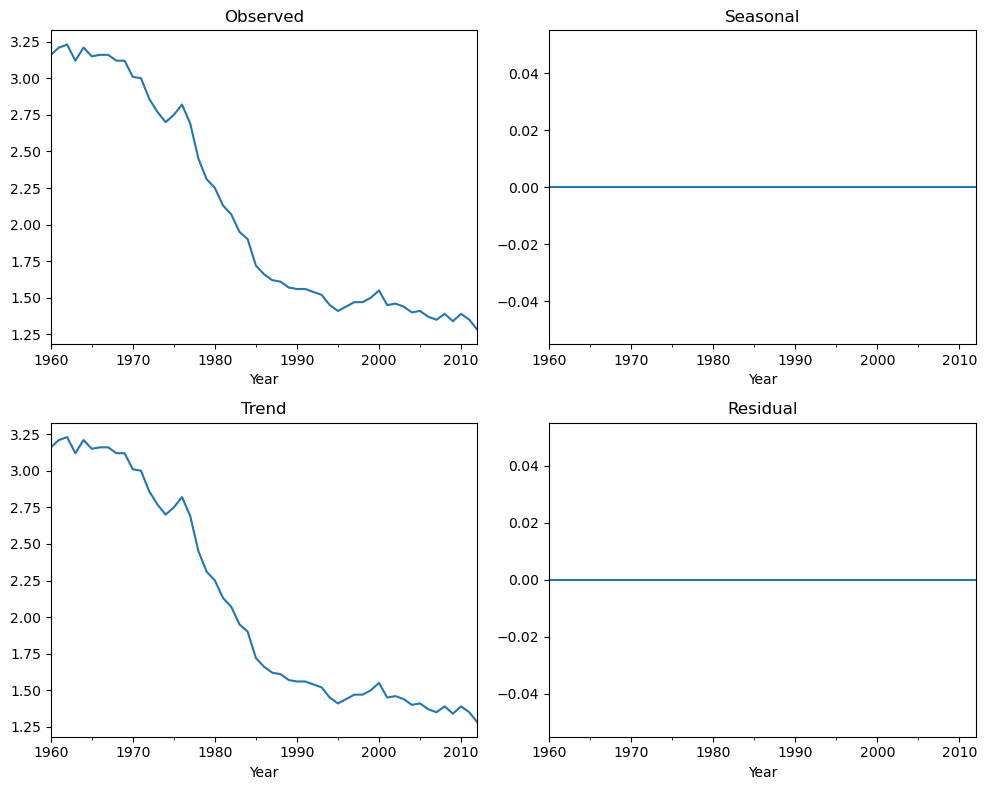

Year
1960-01-01    0.0
1961-01-01    0.0
1962-01-01    0.0
1963-01-01    0.0
1964-01-01    0.0
1965-01-01    0.0
1966-01-01    0.0
1967-01-01    0.0
1968-01-01    0.0
1969-01-01    0.0
1970-01-01    0.0
1971-01-01    0.0
1972-01-01    0.0
1973-01-01    0.0
1974-01-01    0.0
1975-01-01    0.0
1976-01-01    0.0
1977-01-01    0.0
1978-01-01    0.0
1979-01-01    0.0
1980-01-01    0.0
1981-01-01    0.0
1982-01-01    0.0
1983-01-01    0.0
1984-01-01    0.0
1985-01-01    0.0
1986-01-01    0.0
1987-01-01    0.0
1988-01-01    0.0
1989-01-01    0.0
1990-01-01    0.0
1991-01-01    0.0
1992-01-01    0.0
1993-01-01    0.0
1994-01-01    0.0
1995-01-01    0.0
1996-01-01    0.0
1997-01-01    0.0
1998-01-01    0.0
1999-01-01    0.0
2000-01-01    0.0
2001-01-01    0.0
2002-01-01    0.0
2003-01-01    0.0
2004-01-01    0.0
2005-01-01    0.0
2006-01-01    0.0
2007-01-01    0.0
2008-01-01    0.0
2009-01-01    0.0
2010-01-01    0.0
2011-01-01    0.0
2012-01-01    0.0
Name: seasonal, dtype: float64

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Select data from a single country:
# PRT - Portugal
dataSingleCountry = dataIn.loc[dataIn['CountryCode'] == 'PRT']


# Create a time series using 'Year' as the index
dataSingleCountry['Year'] = pd.to_datetime(dataSingleCountry['Year'], format='%Y')
dataSingleCountry.set_index('Year', inplace=True)

# Run seasonal decomposition on the 'Value_fertility' column
result = seasonal_decompose(dataSingleCountry['Value_fertility'], model='additive', period=1)

# Plot the decomposed time series
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
result.observed.plot(ax=axes[0,0], title='Observed')
result.trend.plot(ax=axes[1,0], title='Trend')
result.seasonal.plot(ax=axes[0,1], title='Seasonal')
result.resid.plot(ax=axes[1,1], title='Residual')

plt.tight_layout()
plt.show()



# # Assuming your time series data is in a pandas DataFrame called 'data' with a datetime index

# result = seasonal_decompose(dataSingleCountry['Value_fertility'], model='additive', period = dataSingleCountry['Year'])
# result.plot()

result.seasonal
# dataSingleCountry

/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


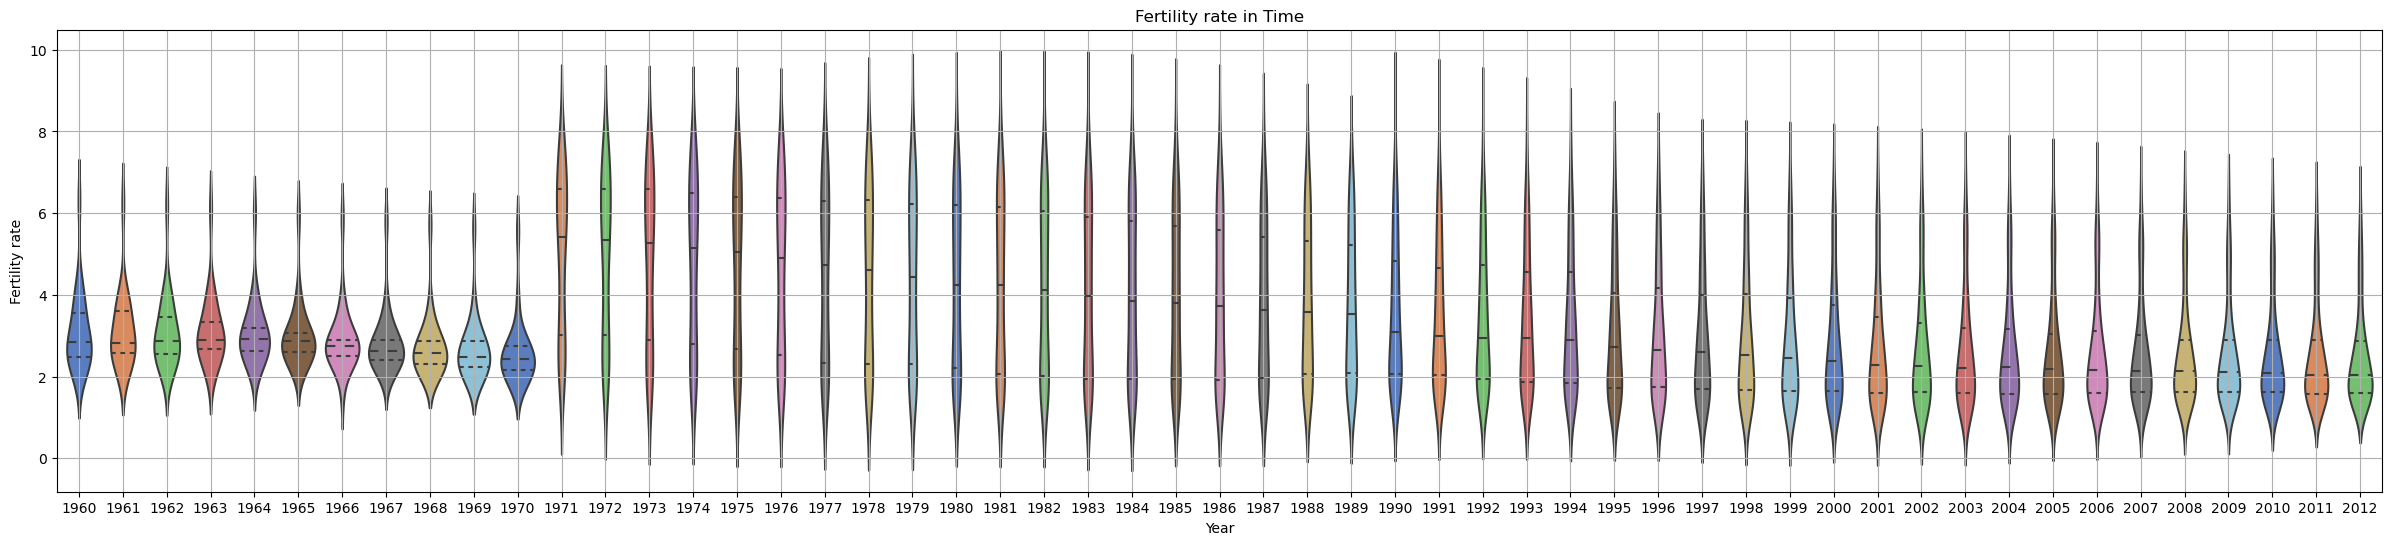

/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


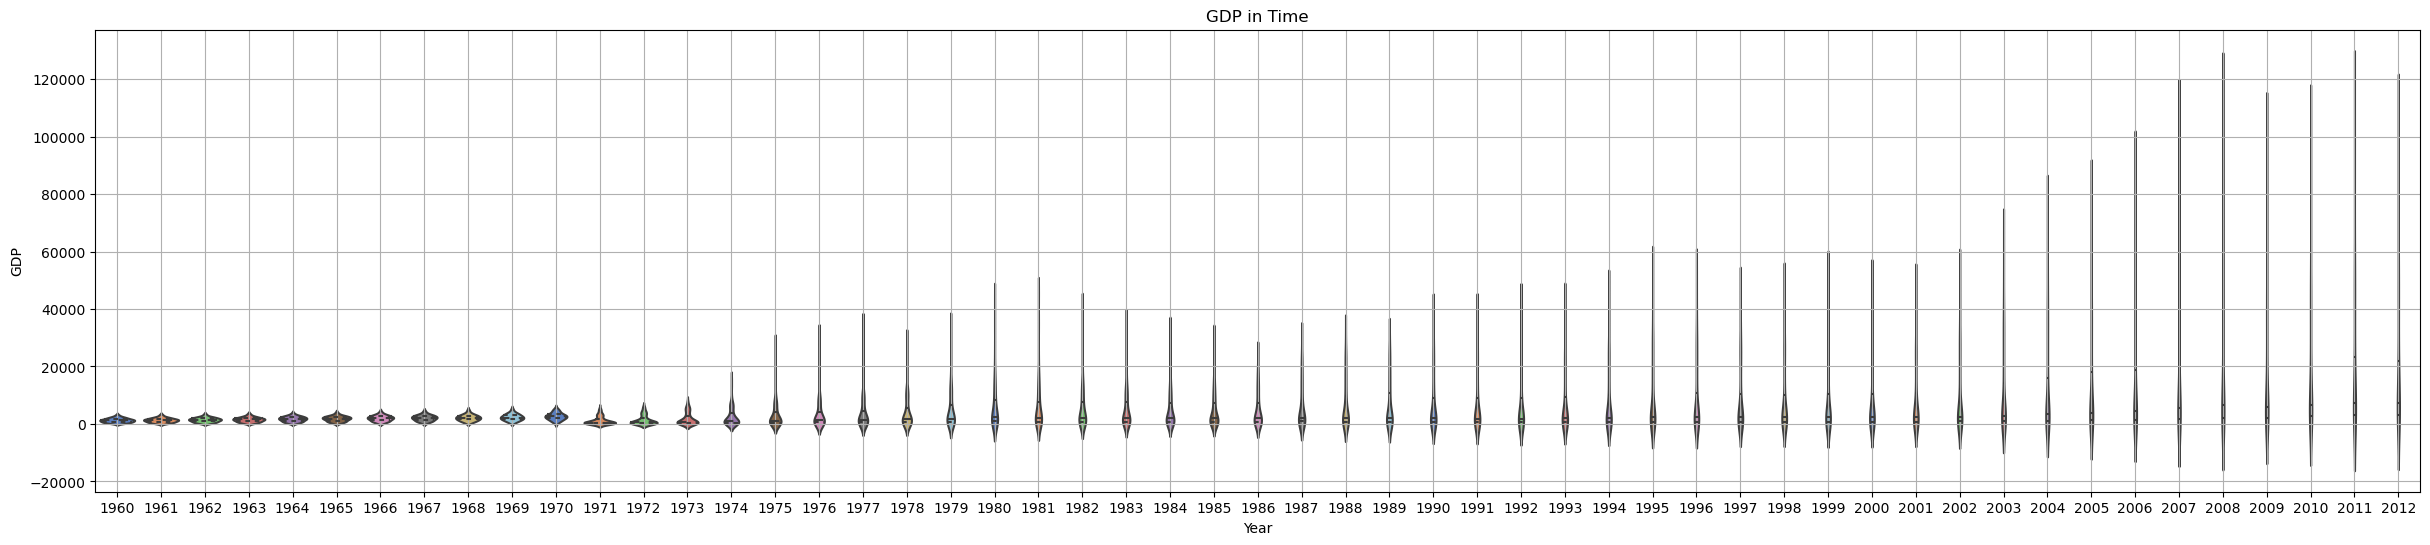

/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


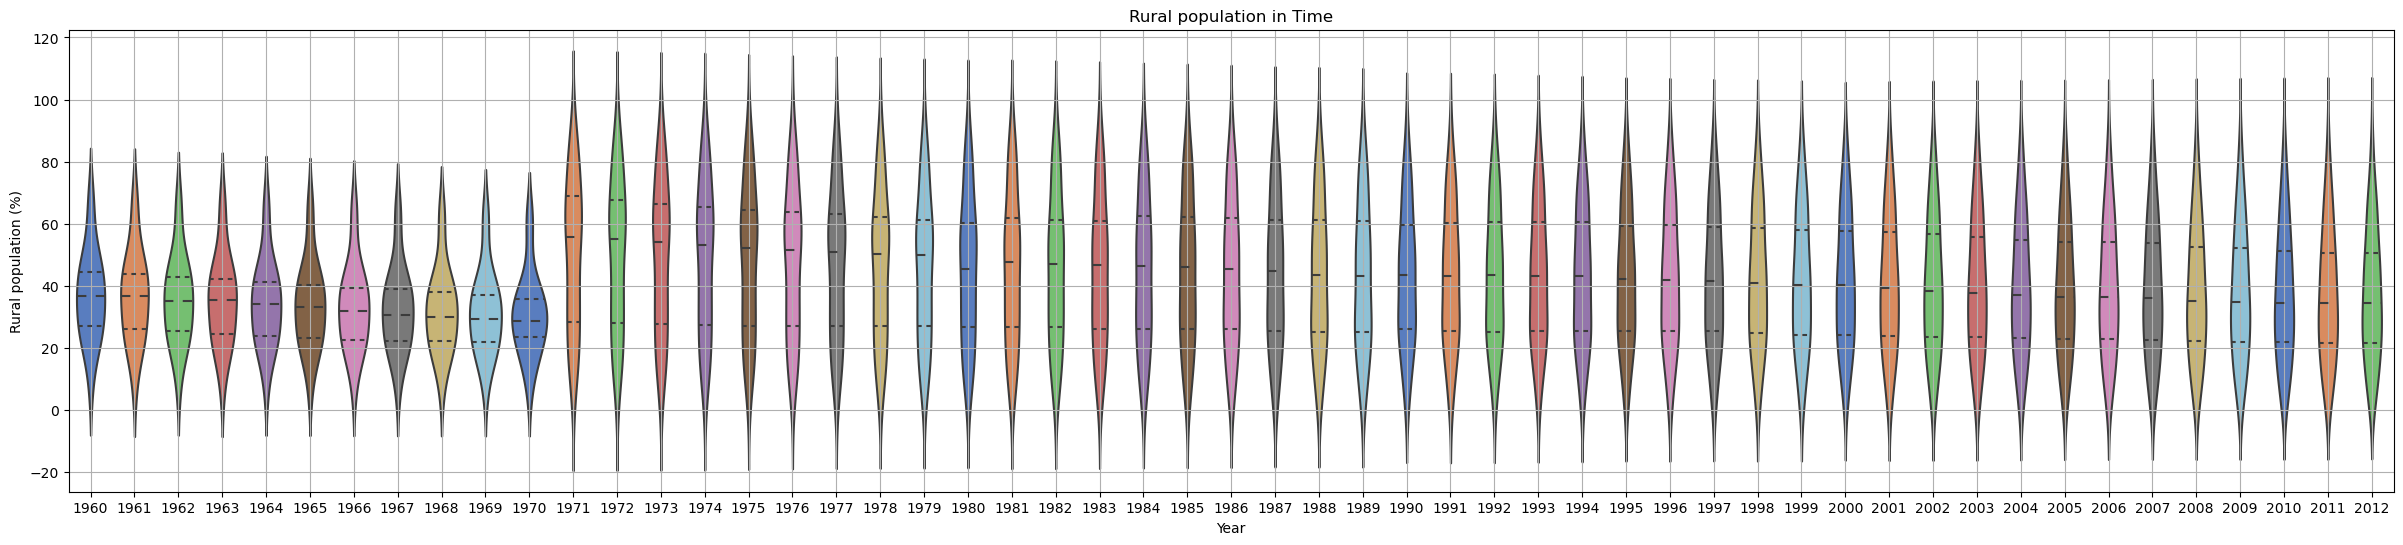

/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


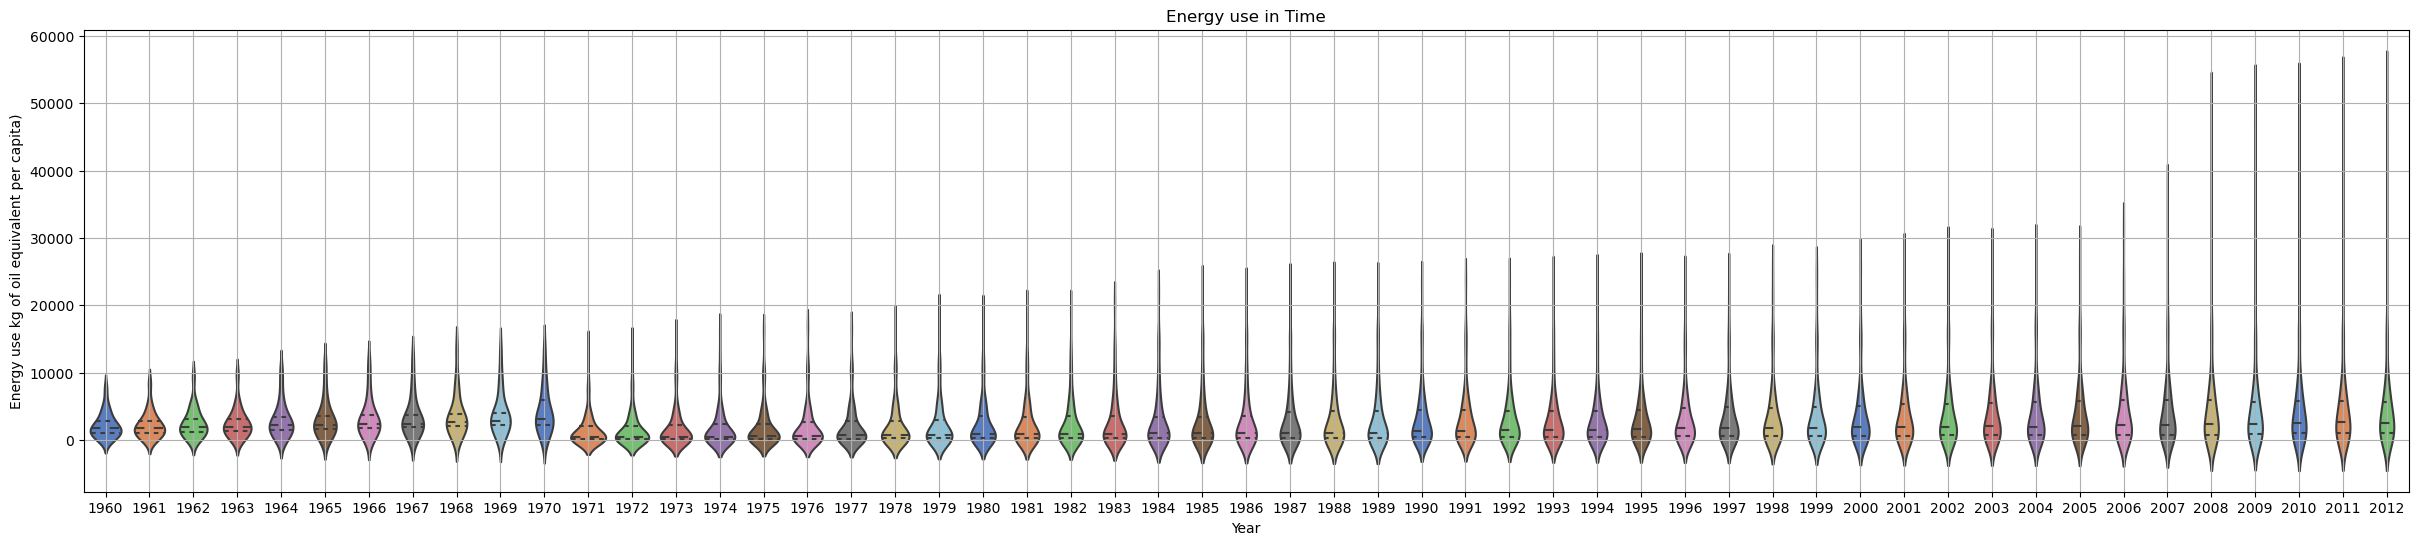

In [8]:
# Decide on the time window to use:
# Create the violin plot for actual data only

# Fertility rate plot
plt.figure(figsize=(30, 6))
sns.violinplot(x='Year', y='Value_fertility', data=dataIn, inner="quart", palette="muted")
plt.xlabel('Year')
plt.ylabel('Fertility rate')
plt.title('Fertility rate in Time')
plt.grid(True)
plt.show()

# GDP plot
plt.figure(figsize=(30, 6))
sns.violinplot(x='Year', y='Value_gdp', data=dataIn, inner="quart", palette="muted")
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP in Time')
plt.grid(True)
plt.show()

# Rural population (%) plot
plt.figure(figsize=(30, 6))
sns.violinplot(x='Year', y='Value_rural', data=dataIn, inner="quart", palette="muted")
plt.xlabel('Year')
plt.ylabel('Rural population (%)')
plt.title('Rural population in Time')
plt.grid(True)
plt.show()

# Energy use (kg of oil equivalent per capita)
plt.figure(figsize=(30, 6))
sns.violinplot(x='Year', y='Value_energy', data=dataIn, inner="quart", palette="muted")
plt.xlabel('Year')
plt.ylabel('Energy use kg of oil equivalent per capita)')
plt.title('Energy use in Time')
plt.grid(True)
plt.show()


# NOTE:

It looks like after 1971 some countries got included into the equation. - Maybe something changed in the way data was collected. I'll be excluding data prior to 1972.

And something might have happened in 2013 as well, exclude that year, as I don't have 2 of those years for test and control groups.

In [9]:
# Exclude here some data in time (prior to 1972 and after 2012).

dataForMod = dataIn[(dataIn['Year'] > 1971) & (dataIn['Year'] < 2013)]


# Data in format for correlation
dataForModRelevantColumns = dataForMod[['Value_fertility', 'Value_gdp', 'Value_rural', 'Value_energy']]

dataForModRelevantColumns

,Value_fertility,Value_gdp,Value_rural,Value_energy
337,7.597,439.731073,60.169,142.029428
338,3.148,1401.487738,20.257,920.471534
339,2.744,3940.861981,14.319,3880.928891
340,2.080,2917.004844,34.689,3404.469208
341,6.928,93.051002,91.779,10.506302
...,...,...,...,...
4996,2.417,12771.595036,11.149,3412.681308
4997,1.768,1755.265424,68.332,1272.539255
4998,4.416,1289.034078,67.126,170.077377
4999,5.511,1686.618024,60.413,571.261200


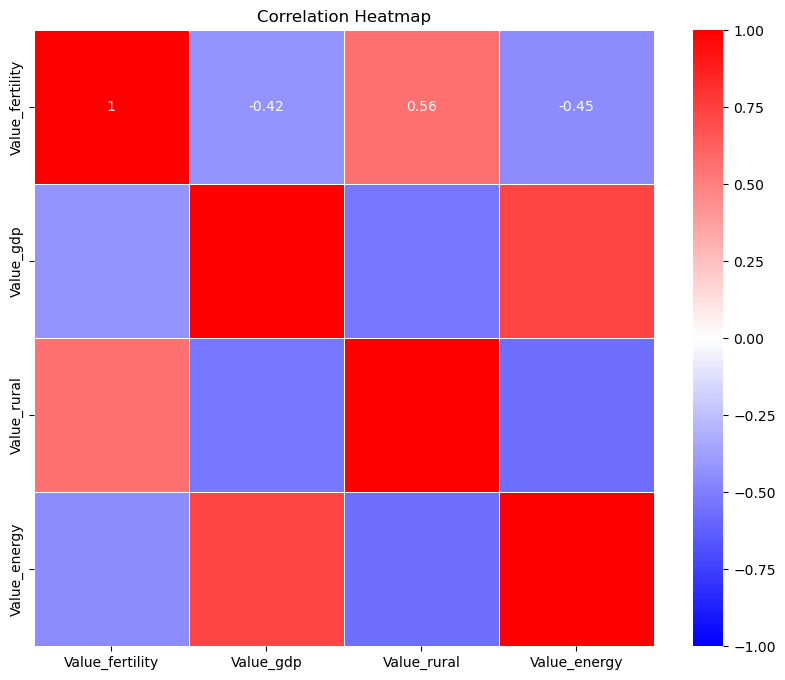

In [10]:
# Check the correlation between inputs 
# Test the correlation with a heatmap visulization

# Assuming 'dataForMod' is your DataFrame with numeric columns
correlation_matrix = dataForModRelevantColumns.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

# plt.savefig('correlation_heatmap.png', format='png')

plt.show()

In [11]:
# Create a fit and test groups.
# Use all odd years for the fit and all even years for the test:

auxData_fit = dataForMod[dataForMod['Year'] % 2 != 0] # The odd numbers
y_fit = auxData_fit['Value_fertility']
X_fit = auxData_fit[['Value_gdp', 'Value_rural', 'Value_energy', 'Year']]


auxData_test = dataForMod[dataForMod['Year'] % 2 == 0] # The even numbers
y_test = auxData_test['Value_fertility']
X_test = auxData_test[['Value_gdp', 'Value_rural', 'Value_energy', 'Year']]


# Do some regularization before inputing it into the model
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the feature matrix X
X_scaled = scaler.fit_transform(X_fit)

X_test_scaled = scaler.fit_transform(X_test)

# The model (fit)

model = LinearRegression()

model.fit(X_scaled, y_fit)

model


mse = mean_squared_error(y_fit, model.predict(X_scaled))

print("MODEL Mean Squared Error:", mse)

# Calculate R-squared
r2 = r2_score(y_fit, model.predict(X_scaled))
print("MODEL R-squared:", r2)

# Access the coefficients (weights) and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print the coefficients and intercept
print("MODEL Coefficients:", coefficients)
print("MODEL Intercept:", intercept)

# Test the model/prediction

predictions = model.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, model.predict(X_test_scaled))

# Calculate R-squared
r2 = r2_score(y_test, model.predict(X_test_scaled))
print()
print(f'TEST Mean Squared Error: {mse}')
print(f'TEST R-squared: {r2}')


MODEL Mean Squared Error: 1.8609606082837478
MODEL R-squared: 0.4414748256975858
MODEL Coefficients: [ 0.09003101  0.80469139 -0.33581143 -0.59752481]
MODEL Intercept: 3.3539458901098924

TEST Mean Squared Error: 1.8575909423559192
TEST R-squared: 0.4459023947245544


/tmp/ipykernel_88458/1972097548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_toplot.loc[:, 'Value_fertility_predicted'] = predictions
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.

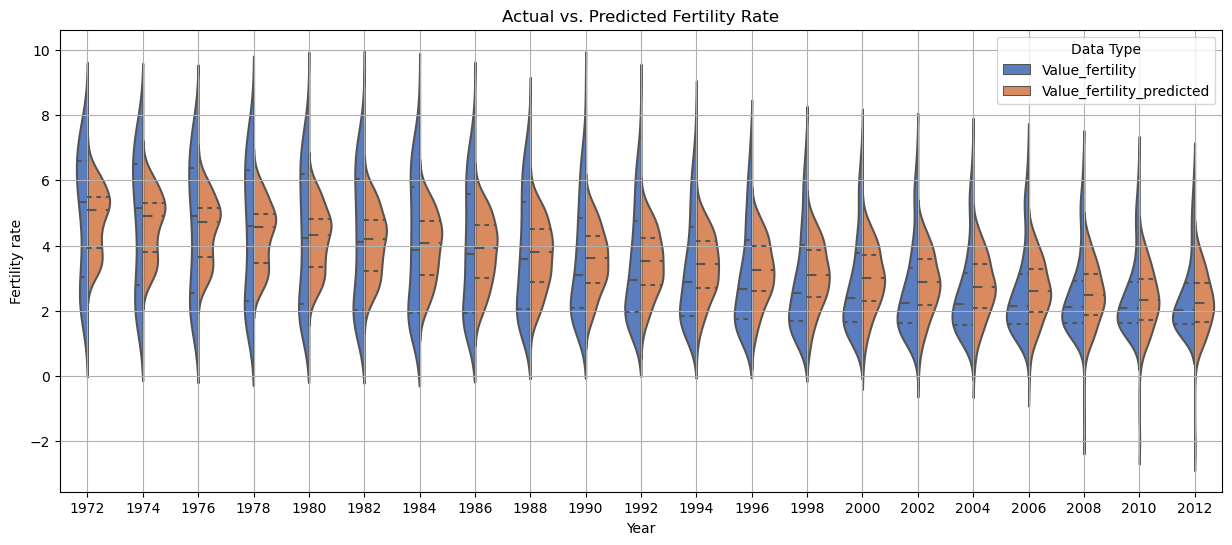

In [12]:
# Visualize data: actual and prediction from multilinear regression model.

data_test_toplot = auxData_test[['Year', 'Value_fertility']]

data_test_toplot.loc[:, 'Value_fertility_predicted'] = predictions

df_melted = pd.melt(data_test_toplot, id_vars=['Year'], var_name='Data_Type', value_name='Value')

# Create the violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(x='Year', y='Value', hue='Data_Type', data=df_melted, split=True, inner="quart", palette="muted")
plt.xlabel('Year')
plt.ylabel('Fertility rate')
plt.title('Actual vs. Predicted Fertility Rate')
plt.legend(title='Data Type')
plt.grid(True)

plt.savefig('violin_actual_predicted.png', format='png')

plt.show()



In [13]:
# Make model output into a pretty table:
# pip install PrettyTable
# conda install -c conda-forge prettytable

from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Add columns to the table
table.field_names = ["Predictor", "Coefficient"]

# Add rows to the table
table.add_row(["GDP", f"{coefficients[0]:.3f}"])
table.add_row(["Rural Pop%", f" {coefficients[1]:.3f}"])
table.add_row(["Energy Use", f"{coefficients[2]:.3f}"])
table.add_row(["Time", f"{coefficients[3]:.3f}"])

# Print the table
print(table)


+------------+-------------+
| Predictor  | Coefficient |
+------------+-------------+
|    GDP     |    0.090    |
| Rural Pop% |     0.805   |
| Energy Use |    -0.336   |
|    Time    |    -0.598   |
+------------+-------------+


Based on the fact that there are significant correlations between the different variables/columns, I want to try seeing if there are meaningful ways to cluster these data in time.

The plan will be to use dynamic time warping and try to do classification based on the similarities across indicators in time to separate different countries into clusters. And finally plot it on a map.


# Part 2: Clustering

In [14]:
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

In [15]:
# Convert the DataFrame into a pivoted format

# Do some regularization before inputing it into the model
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the feature matrix X
X_scaled = scaler.fit_transform(X_fit)

X_test_scaled = scaler.fit_transform(X_test)


dataForDTW = dataForMod[['CountryCode', 'Year', 'Value_fertility', 'Value_gdp', 'Value_rural', 'Value_energy']]

pivoted = dataForDTW.pivot(index='CountryCode', columns='Year')
pivoted.columns = [f"{col[0]}_{col[1]}" for col in pivoted.columns.to_flat_index()]

auxUniqueCountries = dataForDTW['CountryCode'].unique().tolist()
len(auxUniqueCountries) # 165 countries
pivoted.shape
auxUniqueYears = dataForDTW['Year'].unique().tolist()
len(auxUniqueYears) # 41 years

len(pivoted.columns) # This is 4 indicators * 41 years - should be 164

164

In [16]:
# Extract values and reshape for clustering

reshaped_array = pivoted.values.reshape(\
                                        pivoted.shape[0],\
                                        len(pivoted.columns) // len(auxUniqueYears),\
                                        len(auxUniqueYears))

# Transpose the array
reshaped_array = np.transpose(reshaped_array, axes=(0, 1, 2))

# Check the shape of the reshaped array
print('(countries, indicators, years): ', reshaped_array.shape)

(countries, indicators, years):  (135, 4, 41)


In [17]:
dataForDTW

# Data preparation for clustering in time:
dataForDTW = dataForMod[['CountryCode', 'Year', 'Value_fertility']]

# Pivot the data to a time series format suitable for DTW
pivoted = dataForDTW.pivot_table(index='CountryCode', columns='Year', values='Value_fertility')
# Remove countries with NaNs
pivoted.dropna(axis=0, how='any', inplace=True)

# Extract the values
X = pivoted.values

# Fill NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# # Normalize the data
# scaler = StandardScaler()
# X_normalized = scaler.fit_transform(X_imputed)
X_normalized = X_imputed

Problem: the clusters are not stable accross iterations.

For 2 clusters, WCSS: 6.52690666971025
For 3 clusters, WCSS: 3.251186999382295
For 4 clusters, WCSS: 2.138739475975341
For 5 clusters, WCSS: 1.5257834894978417
For 6 clusters, WCSS: 1.4112919516291447
For 7 clusters, WCSS: 1.1855854372207988
For 8 clusters, WCSS: 1.0373217615416608
For 9 clusters, WCSS: 0.9576399280010907
For 10 clusters, WCSS: 0.8729063171169927
For 11 clusters, WCSS: 0.8615002878110322
For 12 clusters, WCSS: 0.6788331561950693
For 13 clusters, WCSS: 0.558598813211069
For 14 clusters, WCSS: 0.45760168886279357
For 15 clusters, WCSS: 0.4249388314385072
For 16 clusters, WCSS: 0.4496108264208304
For 17 clusters, WCSS: 0.4218148082067073
For 18 clusters, WCSS: 0.3405878391590641
For 19 clusters, WCSS: 0.28864146005031033
For 20 clusters, WCSS: 0.30796317353464236
For 21 clusters, WCSS: 0.25234721386164816
For 22 clusters, WCSS: 0.2446940501367803
For 23 clusters, WCSS: 0.20501529546045924
For 24 clusters, WCSS: 0.2071036253931113
For 25 clusters, WCSS: 0.18370953984453794

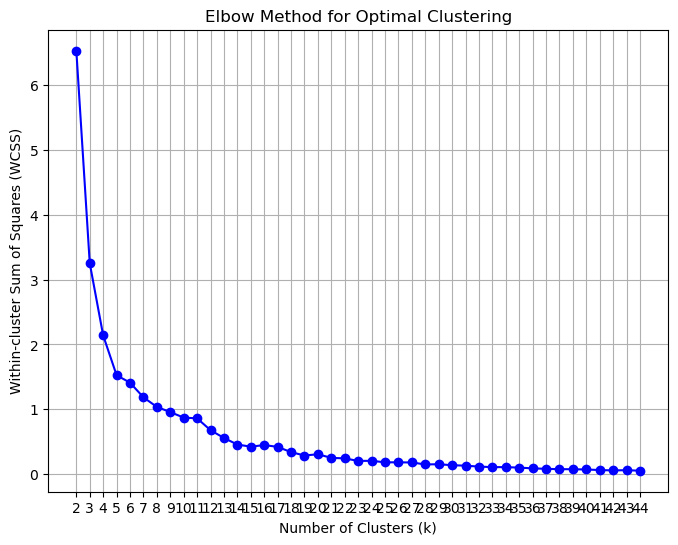

In [18]:
# Analysis for different cluster sizes to find the 'best' number of clusters:

cluster_min = 2
cluster_max = 45

# Loop through different cluster counts
centroid_errors = []  # Create an empty list to store centroid errors
for n_clusters in range(cluster_min, cluster_max):  # Considering clusters from 2 to 10
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw") # No verbose this time
    y_pred = model.fit_predict(X_normalized)

    
    # Get the sum of the within cluster squared error
    sum_centroid_error = model.inertia_
    
    centroid_errors.append(sum_centroid_error)  # Append the error to the list

    print(f"For {n_clusters} clusters, WCSS: {sum_centroid_error}")
    
    
plt.figure(figsize=(8, 6))
plt.plot(range(cluster_min, cluster_max), centroid_errors, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(range(cluster_min, cluster_max))
plt.grid(True)
plt.show()



In [19]:
# Perform Time Series KMeans clustering using Euclidean distance
n_clusters = 11  # Set the number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
# model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True)

y_pred = model.fit_predict(X_normalized)
sum_centroid_error = model.inertia_
centroid_positions = model.cluster_centers_

# Display the predicted clusters
print(y_pred)


5.732 --> 4.343 --> 4.252 --> 4.252 --> 
[ 2  7  7  7  8  0  5  5  7  2 10  3  3  9  5  5  1  7  7  6  8  6  0  1
  7  7  0  7  9  1  0  1  0  5  6  2  2  2  1  5  4  7  4  1  2  7  6  6
  7  5  3  8  7  7  0  4  9  5  6  0  1  0  8  4  9  3  6  7 10  2  6  5
  2  7  5  6  3  3  4]


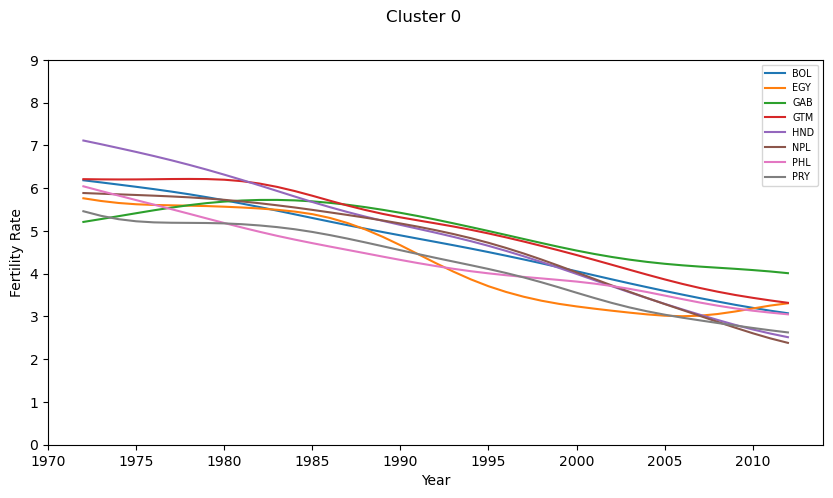

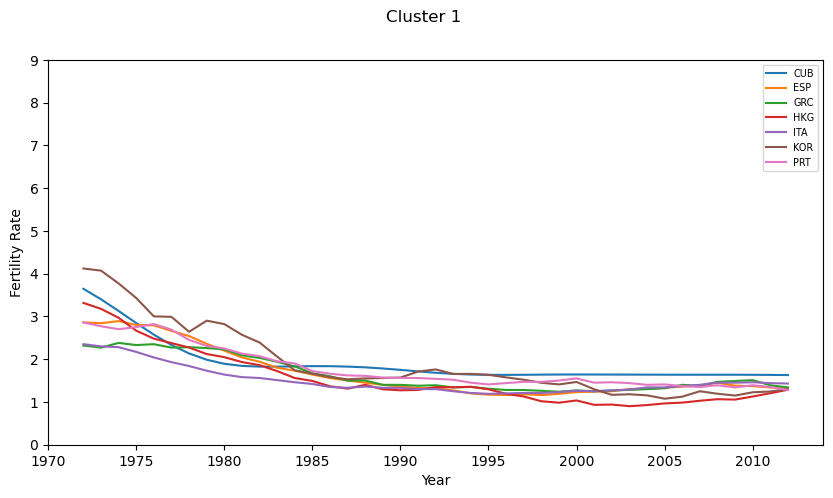

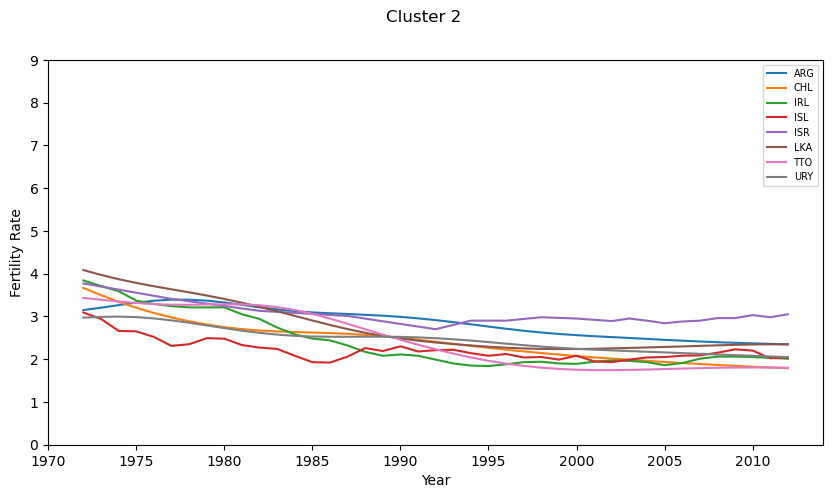

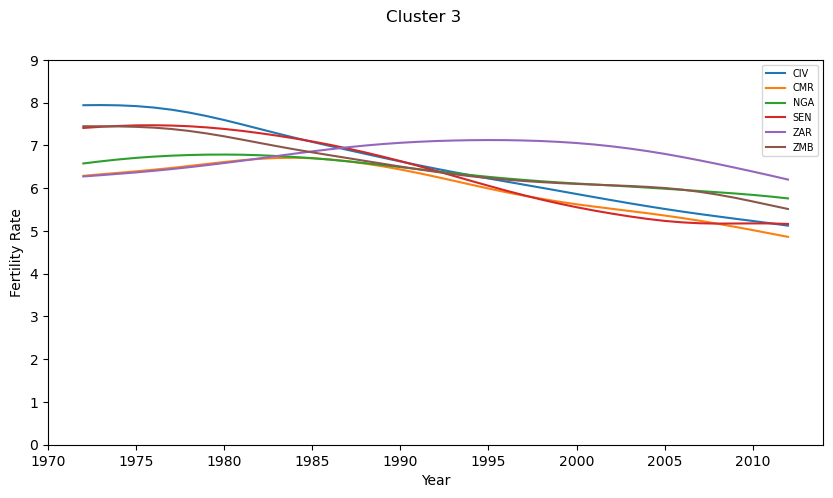

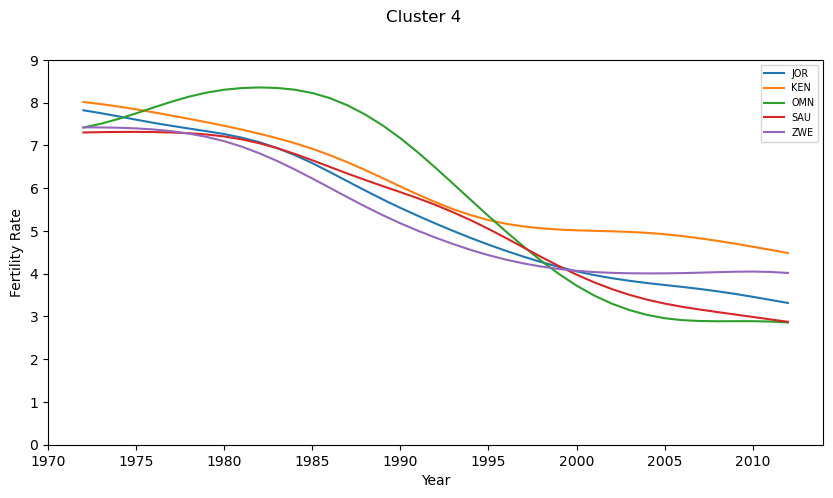

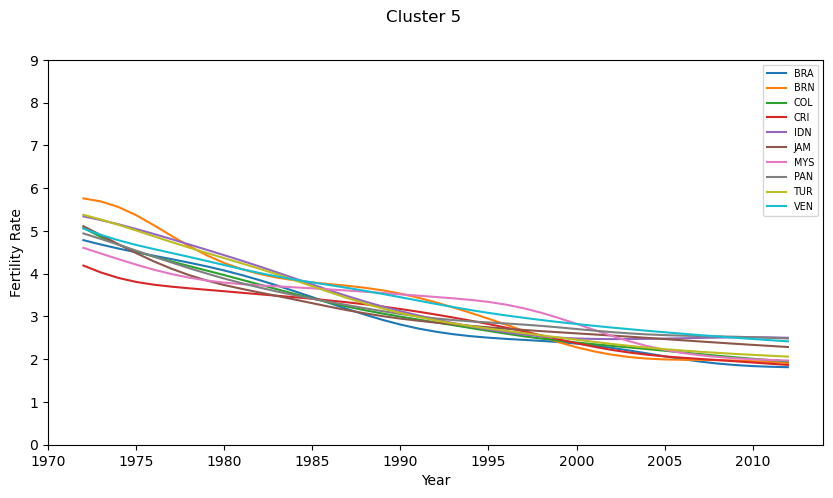

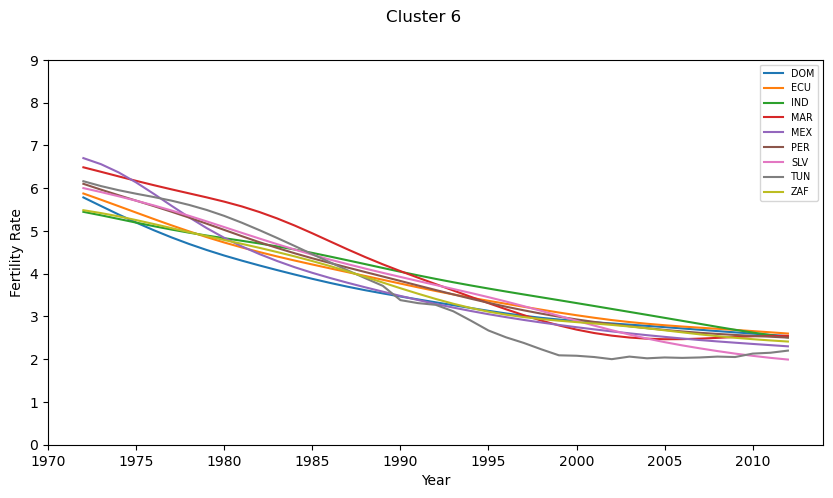

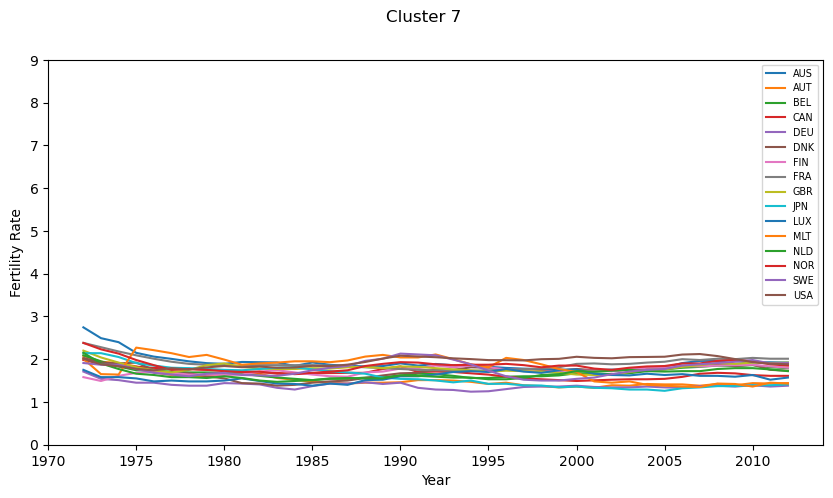

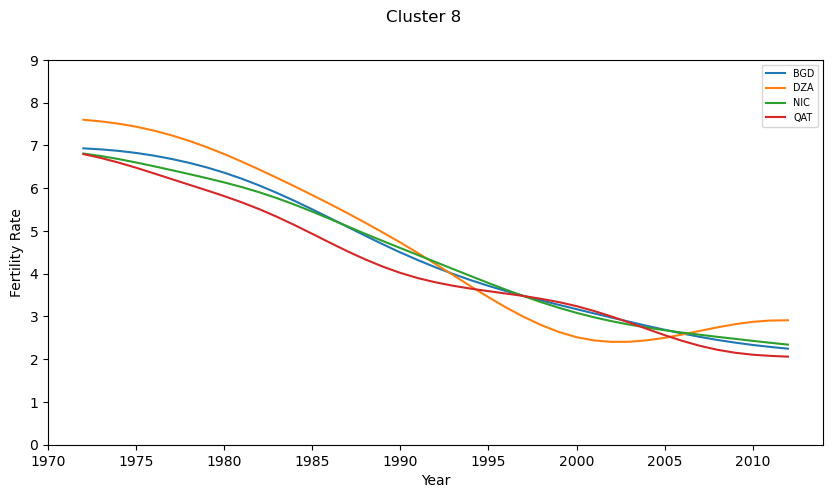

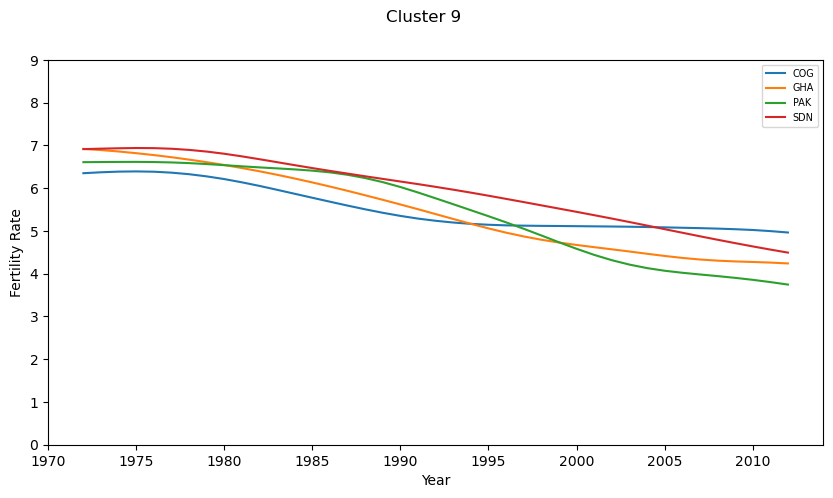

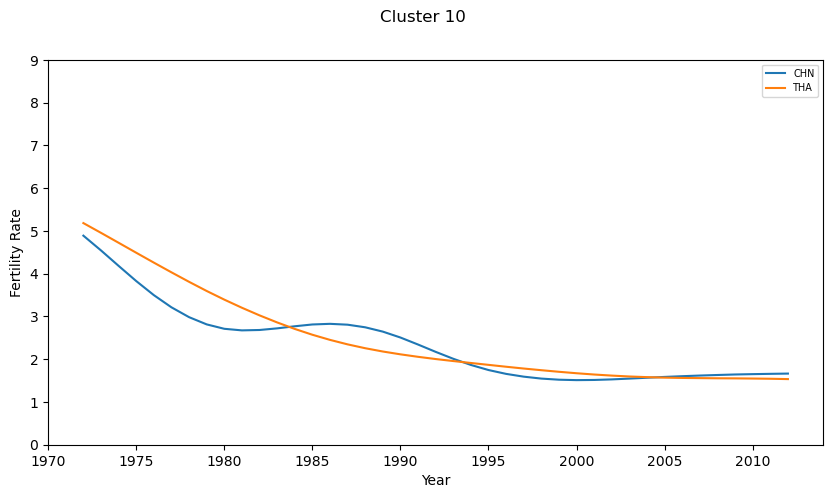

In [20]:
# Assuming 'data_with_clusters' is a DataFrame containing CountryCodes and their respective clusters

data_with_clusters = pd.concat([pivoted, pd.Series(y_pred, name='Cluster', index=pivoted.index)], axis=1)
# Display the 'pivoted' table along with the 'Cluster' column
# print(data_with_clusters)


min_fertility = min(0, data_with_clusters.iloc[:, :-1].values.min())  # Excluding the 'Cluster' column
max_fertility = max(9, data_with_clusters.iloc[:, :-1].values.max())  # Excluding the 'Cluster' column


# Grouping data based on clusters
for cluster in range(n_clusters):
    cluster_data_loc = data_with_clusters[data_with_clusters['Cluster'] == cluster]

    countries = cluster_data_loc.index.tolist()

    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Cluster {cluster}')

    for country in countries:
        country_data = cluster_data_loc.loc[country][:-1]  # Extract fertility data, excluding the 'Cluster' column

        plt.plot(country_data.index, country_data, label=country)

    plt.xlabel('Year')
    plt.ylabel('Fertility Rate')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.ylim(min_fertility, max_fertility)
    plt.show()


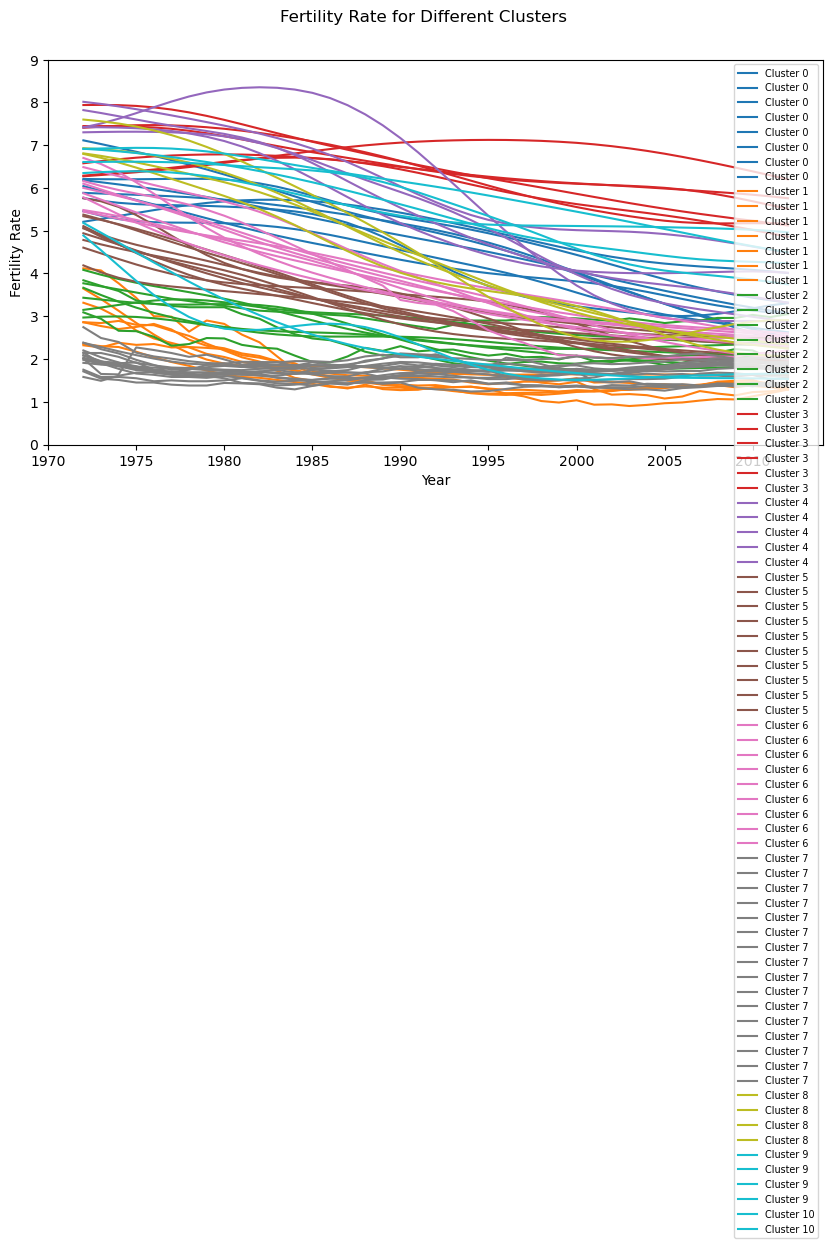

In [21]:
# Grouping data based on clusters - all in the same plot
# n_clusters = 11  # Update the number of clusters

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))  # Generate a set of colors for each cluster

plt.figure(figsize=(10, 5))
plt.suptitle('Fertility Rate for Different Clusters')

for cluster in range(n_clusters):
    cluster_data_loc = data_with_clusters[data_with_clusters['Cluster'] == cluster]

    countries = cluster_data_loc.index.tolist()

    for country in countries:
        country_data = cluster_data_loc.loc[country][:-1]  # Extract fertility data, excluding the 'Cluster' column

        plt.plot(country_data.index, country_data, label=f'Cluster {cluster}', color=colors[cluster])

plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.legend(loc='upper right', fontsize='x-small')
plt.ylim(min_fertility, max_fertility)
plt.show()


From the geopandas data there are a few datasets that are useful.
On the loaded repository of maps, the 'iso_a3' matches the 'CountryCode'. Hence, merging the dataframe containing that map with the clusters should produce something useful.

Available geopandas maps: 'naturalearth_cities', 'naturalearth_lowres', 'nybb'
(run: gpd.datasets.available)

In [22]:
centroid_positions.shape

dataForDTW

,CountryCode,Year,Value_fertility
337,DZA,1972,7.597
338,ARG,1972,3.148
339,AUS,1972,2.744
340,AUT,1972,2.080
341,BGD,1972,6.928
...,...,...,...
4996,VEN,2012,2.417
4997,VNM,2012,1.768
4998,YEM,2012,4.416
4999,ZMB,2012,5.511


/Users/mariana/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:715: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/mariana/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


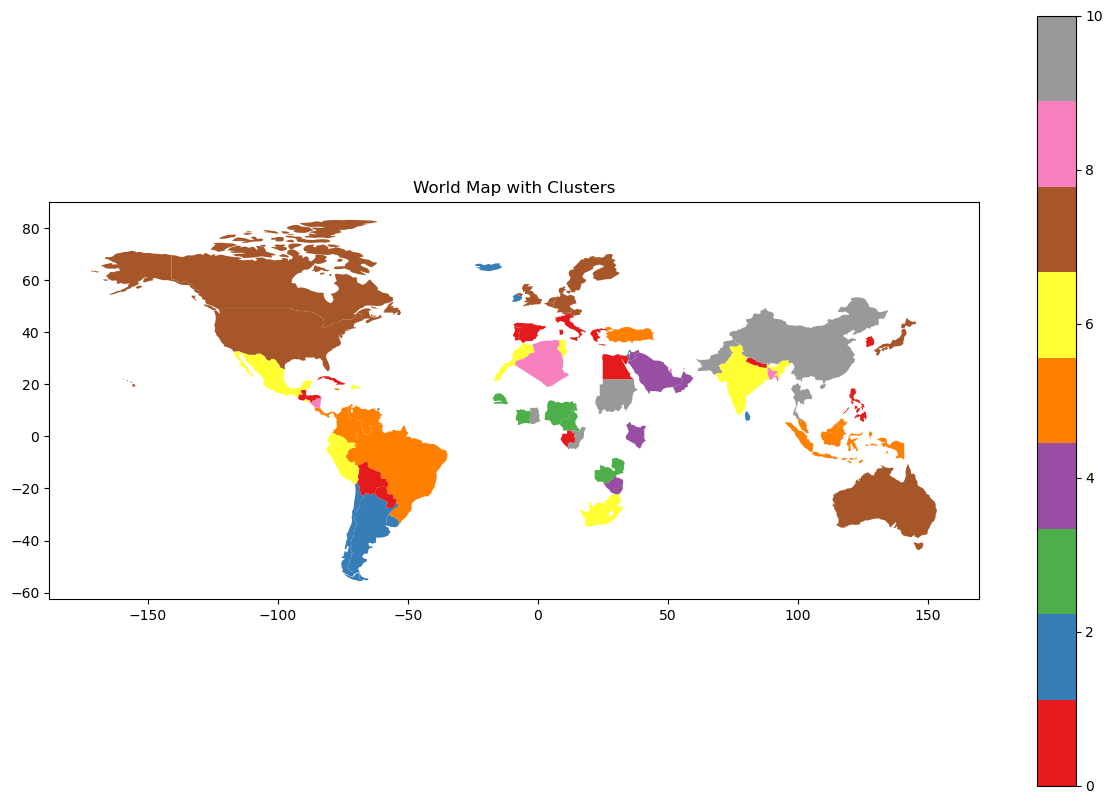

In [23]:
# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Assuming 'cluster_data' is a DataFrame containing CountryCodes and their respective clusters
# Join world map with cluster data
cluster_data = data_with_clusters
world = world.merge(cluster_data, left_on='iso_a3', right_on='CountryCode', how='left')

# Plot world map with country colors based on clusters
world.plot(column='Cluster', cmap='Set1', figsize=(15, 10), legend=True)
plt.title('World Map with Clusters')

# plt.savefig('map_clusteringAll_noRegularization.png', format='png')
plt.savefig('map_clusteringFertitilyOnly_withRegularization_euclideanDistance.png', format='png')


plt.show()


In [24]:
# The maps available with geopandas

world

gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']